## Câu hỏi 6: Dự đoán Giá trị Cầu thủ (Market Value) Mùa Tiếp Theo

### Câu hỏi
Có thể dự đoán 'Giá trị cầu thủ' (Market Value) mùa tiếp theo dựa trên dữ liệu và thống kê cơ bản ở mùa gần nhất hay không?

**Chi tiết:** Xem xét việc áp dụng mô hình có hiệu quả không (độ chính xác)? Nếu không thì trả lời tại sao?

### Motivation & Benefits
* **Lý do nghiên cứu:** Thị trường chuyển nhượng thường bị lạm phát ảo, cần một thước đo chính xác hơn.
* **Lợi ích:** Tránh việc mua hớ hoặc bán rẻ tài năng, định giá dựa trên dữ liệu thực.
* **Đối tượng quan tâm:** Bộ phận đàm phán chuyển nhượng.
* **Vấn đề thực tế:** Cung cấp cơ sở khoa học để đàm phán lương và phí chuyển nhượng.

### 1. Preprocessing - Chuẩn bị dữ liệu cho mô hình dự đoán

Các bước tiền xử lý:
1. **Loại bỏ giá trị null trong biến mục tiêu** (`market_value_in_eur`)
2. **Chọn features phù hợp**: Các đặc trưng liên quan đến hiệu suất và thông tin cầu thủ
3. **Xử lý biến phân loại**: Sử dụng Label Encoding cho các biến categorical
4. **Xử lý missing values**: Điền giá trị thiếu cho các biến số bằng median, biến phân loại bằng mode
5. **Tách tập train-test**: 80% train, 20% test với random_state=42

In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dữ liệu 
df = pd.read_csv('../data/processed_players_data.csv')

# Tạo bản sao để preprocessing
df_model = df.copy()

# Bước 1: Loại bỏ các hàng có market_value_in_eur là null
print(f"Số hàng ban đầu: {len(df_model)}")
df_model = df_model.dropna(subset=['market_value_in_eur'])
print(f"Số hàng sau khi loại bỏ null trong target: {len(df_model)}")
print(f"Số hàng bị loại bỏ: {len(df) - len(df_model)}")

Số hàng ban đầu: 21378
Số hàng sau khi loại bỏ null trong target: 21378
Số hàng bị loại bỏ: 0


In [3]:
# Load dữ liệu từ 2 file CSV đã được chia sẵn
df_train = pd.read_csv('../data/train_data_encoded.csv')  # Thay 'train.csv' bằng tên file train của bạn
df_test = pd.read_csv('../data/test_data_encoded.csv')    # Thay 'test.csv' bằng tên file test của bạn

print("Thông tin dữ liệu Train:")
print(f"- Số hàng: {len(df_train)}")
print(f"- Số cột: {len(df_train.columns)}")

print("\nThông tin dữ liệu Test:")
print(f"- Số hàng: {len(df_test)}")
print(f"- Số cột: {len(df_test.columns)}")

print(f"\nTỷ lệ Train/Test: {len(df_train)/(len(df_train)+len(df_test))*100:.1f}% / {len(df_test)/(len(df_train)+len(df_test))*100:.1f}%")

Thông tin dữ liệu Train:
- Số hàng: 17102
- Số cột: 33

Thông tin dữ liệu Test:
- Số hàng: 4276
- Số cột: 33

Tỷ lệ Train/Test: 80.0% / 20.0%


### Lựa chọn Features

Chúng ta sẽ chọn các features có ý nghĩa để dự đoán giá trị cầu thủ:
- **Thông tin cơ bản**: tuổi, chiều cao, vị trí, chân thuận
- **Hiệu suất thể thao**: tổng bàn thắng, kiến tạo, phút thi đấu, thẻ vàng/đỏ, G+A/90 phút
- **Thông tin hợp đồng**: số năm hợp đồng còn lại, có agent hay không
- **Thông tin câu lạc bộ**: đội bóng hiện tại, giải đấu

In [4]:
# Bước 2: Chọn features
features = [
    'age_at_last_season',
    'height_in_cm',
    'club_position',
    'total_goals',
    'total_assists',
    'total_minutes_played',
    'total_yellow_cards',
    'total_red_cards',
    'has_agent',
    'ga_per90min',
    'contract_years_remaining',
    'last_season',
    'is_champion',
    'is_top_4',
    'is_relegation',
    'current_club_name',
    'country_of_citizenship',
    'current_club_domestic_competition_id',
    'sub_position_Central Midfield',
    'sub_position_Centre-Back',
    'sub_position_Centre-Forward',
    'sub_position_Defensive Midfield',
    'sub_position_Goalkeeper',
    'sub_position_Left Midfield',
    'sub_position_Left Winger',
    'sub_position_Left-Back',
    'sub_position_Right Midfield',
    'sub_position_Right Winger',
    'sub_position_Right-Back',
    'sub_position_Second Striker',
    'foot_left',
    'foot_right'
]

# Kiểm tra xem các features có tồn tại trong cả 2 file không
missing_features_train = [f for f in features if f not in df_train.columns]
missing_features_test = [f for f in features if f not in df_test.columns]

if missing_features_train:
    print(f"Cảnh báo: Các cột sau không có trong train data: {missing_features_train}")
if missing_features_test:
    print(f"Cảnh báo: Các cột sau không có trong test data: {missing_features_test}")

# Tạo X và y cho train set
X_train = df_train[features].copy()
y_train = df_train['market_value_log'].copy()

# Tạo X và y cho test set
X_test = df_test[features].copy()
y_test = df_test['market_value_log'].copy()

print(f"Shape của X_train: {X_train.shape}")
print(f"Shape của y_train: {y_train.shape}")
print(f"Shape của X_test: {X_test.shape}")
print(f"Shape của y_test: {y_test.shape}")

print(f"\nCác features được sử dụng:")
for i, feature in enumerate(features, 1):
    print(f"{i}. {feature}")

Shape của X_train: (17102, 32)
Shape của y_train: (17102,)
Shape của X_test: (4276, 32)
Shape của y_test: (4276,)

Các features được sử dụng:
1. age_at_last_season
2. height_in_cm
3. club_position
4. total_goals
5. total_assists
6. total_minutes_played
7. total_yellow_cards
8. total_red_cards
9. has_agent
10. ga_per90min
11. contract_years_remaining
12. last_season
13. is_champion
14. is_top_4
15. is_relegation
16. current_club_name
17. country_of_citizenship
18. current_club_domestic_competition_id
19. sub_position_Central Midfield
20. sub_position_Centre-Back
21. sub_position_Centre-Forward
22. sub_position_Defensive Midfield
23. sub_position_Goalkeeper
24. sub_position_Left Midfield
25. sub_position_Left Winger
26. sub_position_Left-Back
27. sub_position_Right Midfield
28. sub_position_Right Winger
29. sub_position_Right-Back
30. sub_position_Second Striker
31. foot_left
32. foot_right


### Xử lý Missing Values và Encoding

Chiến lược xử lý:
- **Biến số (numerical)**: Điền bằng giá trị median của cột
- **Biến phân loại (categorical)**: Điền bằng giá trị mode (phổ biến nhất)
- **Label Encoding**: Chuyển đổi các biến categorical thành số để model có thể học

In [5]:
# Kiểm tra missing values trong cả train và test
print("="*60)
print("MISSING VALUES TRONG TRAIN SET:")
print("="*60)
print(X_train.isnull().sum())
print(f"\nTổng missing values: {X_train.isnull().sum().sum()}")

print("\n" + "="*60)
print("MISSING VALUES TRONG TEST SET:")
print("="*60)
print(X_test.isnull().sum())
print(f"\nTổng missing values: {X_test.isnull().sum().sum()}")

# Xác định các cột categorical và numerical
# Lưu ý: position và foot đã được encode thành các cột binary (sub_position_*, foot_left, foot_right)
# Chỉ giữ lại các categorical columns còn tồn tại trong features
categorical_cols = ['current_club_domestic_competition_id']
numerical_cols = [col for col in features if col not in categorical_cols]

print("\n" + "="*60)
print("XỬ LÝ MISSING VALUES")
print("="*60)

# Bước 3: Xử lý missing values cho TRAIN SET
# Numerical: điền bằng median
for col in numerical_cols:
    if X_train[col].isnull().sum() > 0:
        median_value = X_train[col].median()
        X_train[col].fillna(median_value, inplace=True)
        X_test[col].fillna(median_value, inplace=True)  # Dùng median của train cho test
        print(f"Điền {col} bằng median: {median_value:.2f}")

# Categorical: điền bằng mode
for col in categorical_cols:
    if X_train[col].isnull().sum() > 0 or X_test[col].isnull().sum() > 0:
        mode_value = X_train[col].mode()[0] if len(X_train[col].mode()) > 0 else 'Unknown'
        X_train[col].fillna(mode_value, inplace=True)
        X_test[col].fillna(mode_value, inplace=True)  # Dùng mode của train cho test
        print(f"Điền {col} bằng mode: {mode_value}")

print(f"\nMissing values trong Train sau xử lý: {X_train.isnull().sum().sum()}")
print(f"Missing values trong Test sau xử lý: {X_test.isnull().sum().sum()}")

MISSING VALUES TRONG TRAIN SET:
age_at_last_season                      0
height_in_cm                            0
club_position                           0
total_goals                             0
total_assists                           0
total_minutes_played                    0
total_yellow_cards                      0
total_red_cards                         0
has_agent                               0
ga_per90min                             0
contract_years_remaining                0
last_season                             0
is_champion                             0
is_top_4                                0
is_relegation                           0
current_club_name                       0
country_of_citizenship                  0
current_club_domestic_competition_id    0
sub_position_Central Midfield           0
sub_position_Centre-Back                0
sub_position_Centre-Forward             0
sub_position_Defensive Midfield         0
sub_position_Goalkeeper                 0
su

### B. Phân tích dữ liệu trước khi modeling

Trước khi xây dựng mô hình, chúng ta cần hiểu:
1. **Phân phối của biến mục tiêu** (market_value_in_eur)
2. **Tương quan giữa các features và target**
3. **Thống kê mô tả các features**

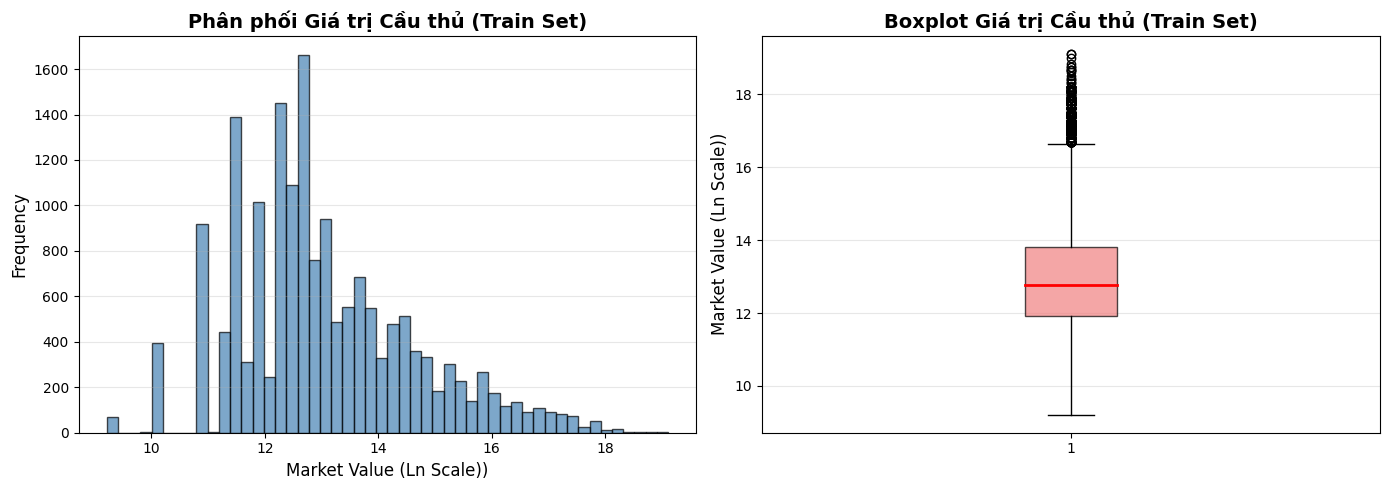

THỐNG KÊ MÔ TẢ - TRAIN SET
Mean:             13.03 Ln(EUR)
Median:              13 Ln(EUR)
Min:                  9 Ln(EUR)
Max:                 19 Ln(EUR)
Std:                  2 Ln(EUR)

THỐNG KÊ MÔ TẢ - TEST SET
Mean:                13 Ln(EUR)
Median:              13 Ln(EUR)
Min:                  9 Ln(EUR)
Max:                 19 Ln(EUR)
Std:                  2 Ln(EUR)


In [6]:
# Phân tích phân phối của target (chỉ dùng train set)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(y_train, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Market Value (Ln Scale))', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Phân phối Giá trị Cầu thủ (Train Set)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Boxplot
axes[1].boxplot(y_train, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightcoral', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Market Value (Ln Scale))', fontsize=12)
axes[1].set_title('Boxplot Giá trị Cầu thủ (Train Set)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Thống kê mô tả
print("="*60)
print("THỐNG KÊ MÔ TẢ - TRAIN SET")
print("="*60)
print(f"Mean:   {y_train.mean():>15.2f} Ln(EUR)")
print(f"Median: {y_train.median():>15,.0f} Ln(EUR)")
print(f"Min:    {y_train.min():>15,.0f} Ln(EUR)")
print(f"Max:    {y_train.max():>15,.0f} Ln(EUR)")
print(f"Std:    {y_train.std():>15,.0f} Ln(EUR)")

print("\n" + "="*60)
print("THỐNG KÊ MÔ TẢ - TEST SET")
print("="*60)
print(f"Mean:   {y_test.mean():>15,.0f} Ln(EUR)")
print(f"Median: {y_test.median():>15,.0f} Ln(EUR)")
print(f"Min:    {y_test.min():>15,.0f} Ln(EUR)")
print(f"Max:    {y_test.max():>15,.0f} Ln(EUR)")
print(f"Std:    {y_test.std():>15,.0f} Ln(EUR)")

In [7]:
# Hiển thị thông tin tổng hợp về dữ liệu đã được chuẩn bị
print("="*80)
print("TỔNG HỢP DỮ LIỆU SAU PREPROCESSING")
print("="*80)

print("\nKích thước các tập dữ liệu:")
print(f"X_train: {X_train.shape} - {len(X_train):,} samples, {X_train.shape[1]} features")
print(f"X_test:  {X_test.shape} - {len(X_test):,} samples, {X_test.shape[1]} features")
print(f"y_train: {y_train.shape} - {len(y_train):,} samples")
print(f"y_test:  {y_test.shape} - {len(y_test):,} samples")

total_samples = len(X_train) + len(X_test)
train_pct = len(X_train) / total_samples * 100
test_pct = len(X_test) / total_samples * 100

print(f"\nTỷ lệ Train/Test: {train_pct:.1f}% / {test_pct:.1f}%")

print("\n" + "="*80)
print("KIỂM TRA DATA QUALITY")
print("="*80)
print(f"✓ Train set - Missing values: {X_train.isnull().sum().sum()}")
print(f"✓ Test set - Missing values: {X_test.isnull().sum().sum()}")
print(f"✓ Train set - Target nulls: {y_train.isnull().sum()}")
print(f"✓ Test set - Target nulls: {y_test.isnull().sum()}")
print("="*80)
print("✓ Dữ liệu đã sẵn sàng cho training!")
print("="*80)

TỔNG HỢP DỮ LIỆU SAU PREPROCESSING

Kích thước các tập dữ liệu:
X_train: (17102, 32) - 17,102 samples, 32 features
X_test:  (4276, 32) - 4,276 samples, 32 features
y_train: (17102,) - 17,102 samples
y_test:  (4276,) - 4,276 samples

Tỷ lệ Train/Test: 80.0% / 20.0%

KIỂM TRA DATA QUALITY
✓ Train set - Missing values: 0
✓ Test set - Missing values: 0
✓ Train set - Target nulls: 0
✓ Test set - Target nulls: 0
✓ Dữ liệu đã sẵn sàng cho training!


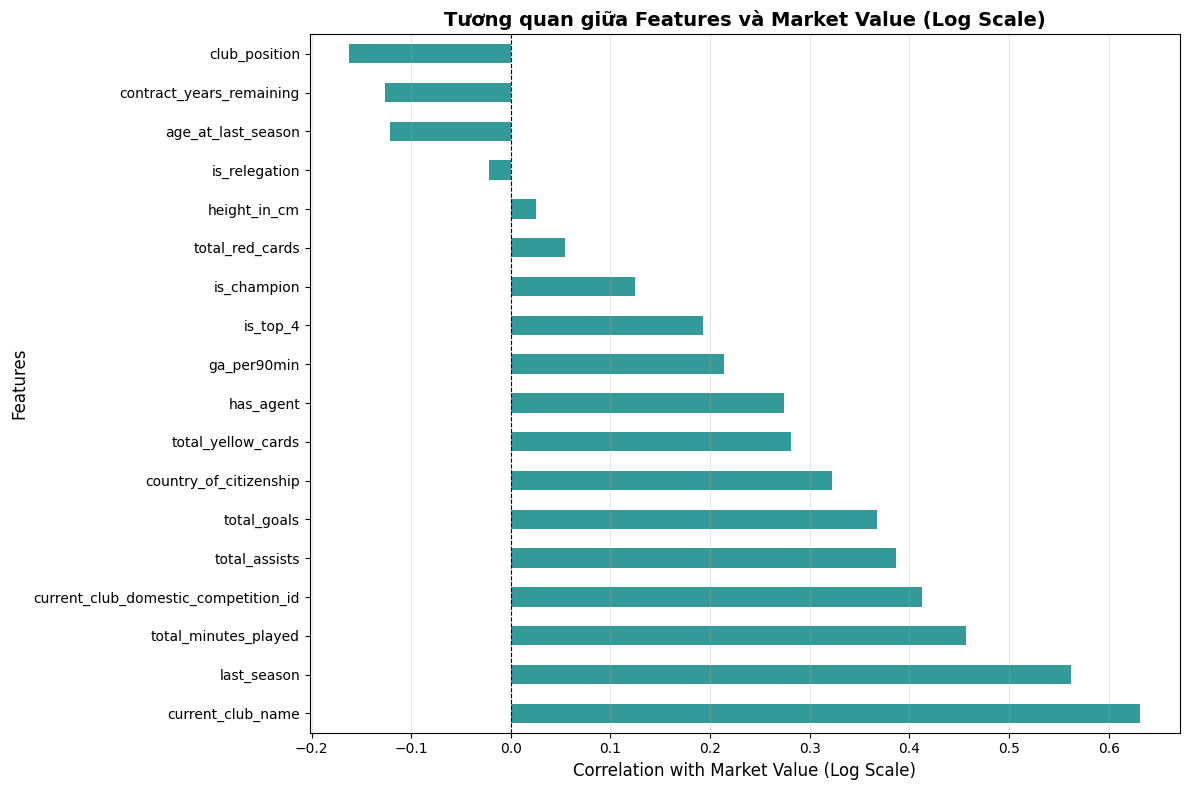


Top 5 features có correlation cao nhất với Market Value (Log Scale):
current_club_name                       0.631764
last_season                             0.561751
total_minutes_played                    0.456805
current_club_domestic_competition_id    0.412079
total_assists                           0.386347
Name: market_value_log, dtype: float64


In [8]:
# Tương quan giữa các numerical features với target (chỉ dùng train set)
X_with_target = X_train.copy()
X_with_target['market_value_log'] = y_train

# Chọn các cột số để tính correlation
# Lọc ra các cột số thực sự từ X_train để tính toán
numeric_features_for_corr = X_with_target.select_dtypes(include=np.number).columns.tolist()
correlation_data = X_with_target[numeric_features_for_corr].corr()['market_value_log'].drop('market_value_log')

# Vẽ biểu đồ correlation
plt.figure(figsize=(12, 8))
correlation_data.sort_values(ascending=False).plot(kind='barh', color='teal', alpha=0.8)
plt.xlabel('Correlation with Market Value (Log Scale)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Tương quan giữa Features và Market Value (Log Scale)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 features có correlation cao nhất với Market Value (Log Scale):")
print(correlation_data.sort_values(ascending=False).head())

### D. Model Selection & Training

**Mô hình được chọn: XGBoost Regressor**

**Lý do chọn XGBoost:**
1. **Hiệu suất cao**: Một trong những thuật toán tốt nhất cho bài toán regression
2. **Xử lý tốt các features phức tạp**: Có thể capture non-linear relationships
3. **Robust với outliers**: Ít nhạy cảm với giá trị ngoại lai
4. **Feature importance**: Cung cấp thông tin về tầm quan trọng của từng feature

**Hyperparameters:**
- `n_estimators=200`: Số lượng cây quyết định
- `learning_rate=0.1`: Tốc độ học
- `max_depth=6`: Độ sâu tối đa của mỗi cây
- `random_state=42`: Đảm bảo reproducibility

In [41]:
# Training XGBoost Model
print("Bắt đầu huấn luyện XGBoost Model...")
print("="*60)

# Khởi tạo model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # Mục tiêu chuẩn cho dự đoán số (Mặc định)
    n_estimators=1000,            # Số lượng cây tối đa
    learning_rate=0.01,           # Tốc độ học chậm để chắc chắn
    max_depth=6,                  # Độ sâu của cây

    subsample=0.8,                # Mỗi cây chỉ học trên 80% dữ liệu ngẫu nhiên
    colsample_bytree=0.8,         # Mỗi cây chỉ nhìn 80% số cột (features)

    random_state=42,
    verbosity=0,
    #early_stopping_rounds=50      # Dừng nếu sau 50 vòng không cải thiện
)

# Train model
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)
print("Huấn luyện hoàn tất!")

# 1. Load lại tập Test gốc
df_test_full = pd.read_csv('../data/test_data_encoded.csv')

# 2. Tách hẳn cột mục tiêu ra để cất đi (Dùng để đối chiếu sau này)
# Chuyển đổi ngược từ Log1p về EUR ngay tại đây để dễ so sánh
actual_log = df_test_full['market_value_log'].values
actual_eur = np.expm1(actual_log) # Dùng expm1 vì lúc train dùng log1p

# 3. Tạo DataFrame "Mù" (Chỉ chứa features, xóa cột market_value_log)
# Lọc đúng các cột features mà mô hình đã được học (theo thứ tự của X_train)
# (Biến features được định nghĩa ở Cell chọn features lúc train)
blind_test_df = df_test_full[features].copy()

print("Kích thước tập test mù:", blind_test_df.shape)
print("Các cột được dùng để dự đoán:", blind_test_df.columns.tolist())

# Dự đoán trên tập train và test
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(blind_test_df)

print("\n" + "="*60)
print("Dự đoán hoàn tất!")

Bắt đầu huấn luyện XGBoost Model...
Huấn luyện hoàn tất!
Kích thước tập test mù: (4276, 32)
Các cột được dùng để dự đoán: ['age_at_last_season', 'height_in_cm', 'club_position', 'total_goals', 'total_assists', 'total_minutes_played', 'total_yellow_cards', 'total_red_cards', 'has_agent', 'ga_per90min', 'contract_years_remaining', 'last_season', 'is_champion', 'is_top_4', 'is_relegation', 'current_club_name', 'country_of_citizenship', 'current_club_domestic_competition_id', 'sub_position_Central Midfield', 'sub_position_Centre-Back', 'sub_position_Centre-Forward', 'sub_position_Defensive Midfield', 'sub_position_Goalkeeper', 'sub_position_Left Midfield', 'sub_position_Left Winger', 'sub_position_Left-Back', 'sub_position_Right Midfield', 'sub_position_Right Winger', 'sub_position_Right-Back', 'sub_position_Second Striker', 'foot_left', 'foot_right']

Dự đoán hoàn tất!


### E. Model Evaluation

**Các metrics đánh giá:**
1. **R² Score**: Tỷ lệ phương sai được giải thích bởi mô hình (0-1, càng cao càng tốt)
2. **MAE (Mean Absolute Error)**: Sai số tuyệt đối trung bình (EUR)
3. **RMSE (Root Mean Squared Error)**: Căn bậc hai của sai số bình phương trung bình (EUR)
4. **MAPE (Mean Absolute Percentage Error)**: Sai số phần trăm tuyệt đối trung bình (%)

In [42]:
# Tính toán các metrics trên cả log scale và EUR scale
def calculate_metrics(y_true_log, y_pred_log, dataset_name):
    """
    Tính metrics trên cả log scale và EUR scale (sau inverse transform)
    """
    # Metrics trên log scale
    r2_log = r2_score(y_true_log, y_pred_log)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    
    # Inverse transform về EUR
    y_true_eur = np.expm1(y_true_log) 
    y_pred_eur = np.expm1(y_pred_log) 
    
    # Metrics trên EUR scale
    r2_eur = r2_score(y_true_eur, y_pred_eur)
    mae_eur = mean_absolute_error(y_true_eur, y_pred_eur)
    rmse_eur = np.sqrt(mean_squared_error(y_true_eur, y_pred_eur))
    mape_eur = np.mean(np.abs((y_true_eur - y_pred_eur) / y_true_eur)) * 100
    
    print(f"\n{'='*80}")
    print(f"Metrics cho {dataset_name}")
    print(f"{'='*80}")
    
    print("\n📊 Ln SCALE:")
    print(f"  R² Score:    {r2_log:.4f}")
    print(f"  MAE:         {mae_log:.4f} (Ln)")
    print(f"  RMSE:        {rmse_log:.4f} (Ln)")
    
    print("\n💶 EUR SCALE (After Inverse Transform):")
    print(f"  R² Score:    {r2_eur:.4f}")
    print(f"  MAE:         {mae_eur:>15,.0f} EUR")
    print(f"  RMSE:        {rmse_eur:>15,.0f} EUR")
    print(f"  MAPE:        {mape_eur:>15.2f}%")
    
    print(f"{'='*80}")
    
    return {
        'R2_log': r2_log, 'MAE_log': mae_log, 'RMSE_log': rmse_log,
        'R2_eur': r2_eur, 'MAE_eur': mae_eur, 'RMSE_eur': rmse_eur, 'MAPE_eur': mape_eur
    }

# Đánh giá trên tập train
train_metrics = calculate_metrics(y_train, y_train_pred, "TRAIN SET")

# Đánh giá trên tập test
test_metrics = calculate_metrics(y_test, y_test_pred, "TEST SET")


Metrics cho TRAIN SET

📊 Ln SCALE:
  R² Score:    0.8425
  MAE:         0.4818 (Ln)
  RMSE:        0.6311 (Ln)

💶 EUR SCALE (After Inverse Transform):
  R² Score:    0.8560
  MAE:                 805,672 EUR
  RMSE:              2,868,630 EUR
  MAPE:                  57.13%

Metrics cho TEST SET

📊 Ln SCALE:
  R² Score:    0.7836
  MAE:         0.5602 (Ln)
  RMSE:        0.7357 (Ln)

💶 EUR SCALE (After Inverse Transform):
  R² Score:    0.7845
  MAE:                 957,858 EUR
  RMSE:              3,648,204 EUR
  MAPE:                  71.00%


### F. Visualization - So sánh giá trị thực tế và dự đoán

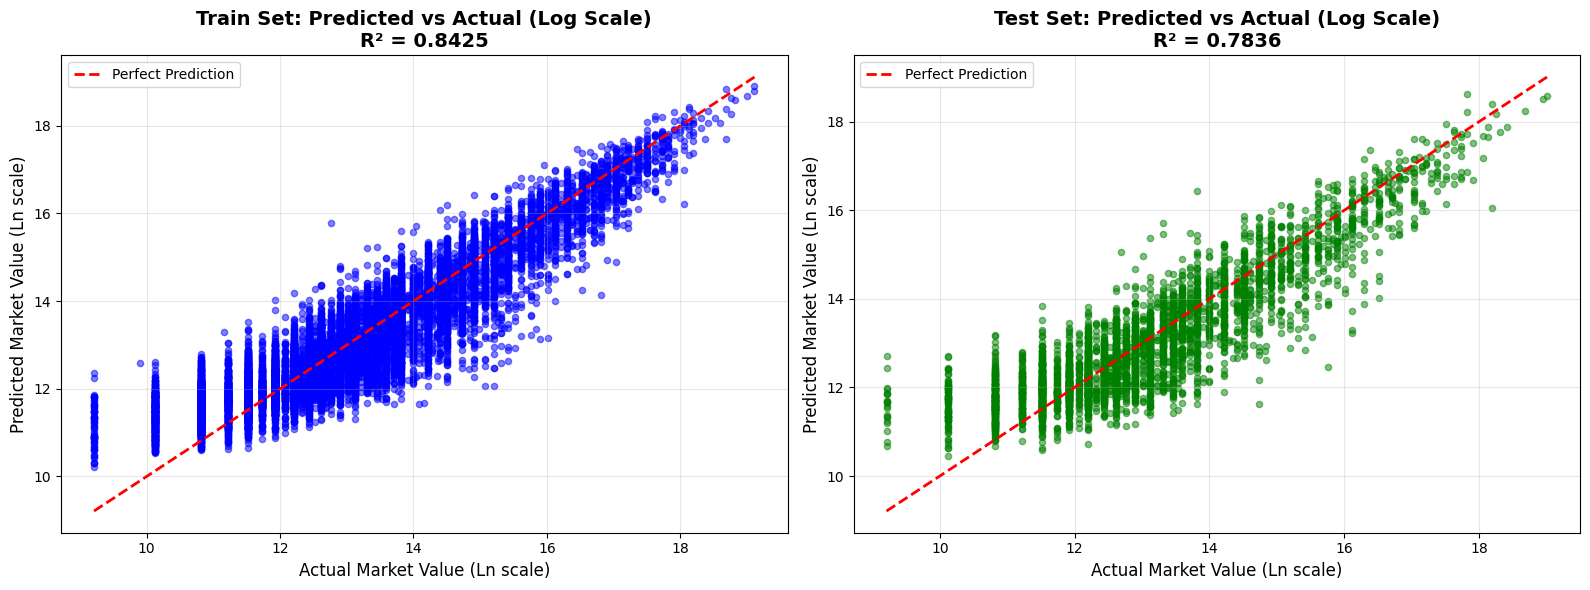

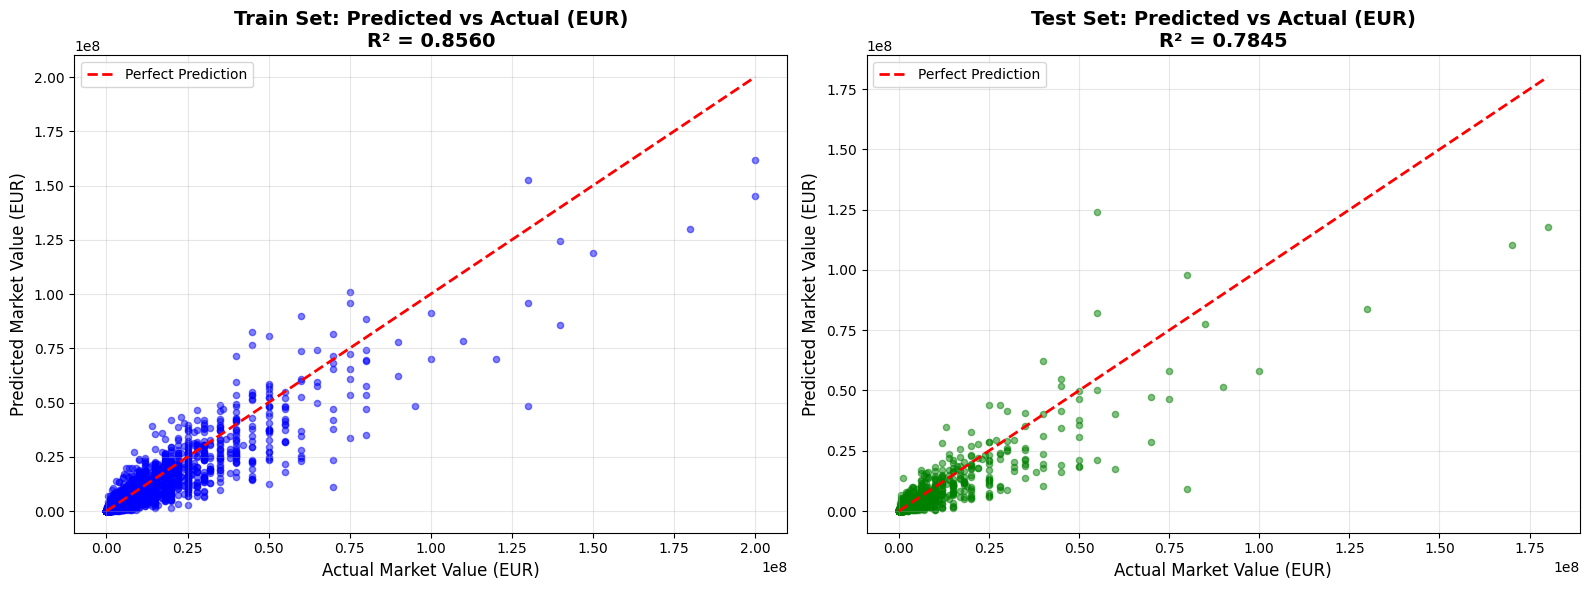

In [43]:
# Vẽ biểu đồ so sánh Predicted vs Actual (LOG SCALE)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train set
axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=20, color='blue')
axes[0].plot([y_train.min(), y_train.max()], 
             [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Market Value (Ln scale)', fontsize=12)
axes[0].set_ylabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[0].set_title(f'Train Set: Predicted vs Actual (Log Scale)\nR² = {train_metrics["R2_log"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.5, s=20, color='green')
axes[1].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Market Value (Ln scale)', fontsize=12)
axes[1].set_ylabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[1].set_title(f'Test Set: Predicted vs Actual (Log Scale)\nR² = {test_metrics["R2_log"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Vẽ thêm biểu đồ ở EUR SCALE
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Inverse transform về EUR
y_train_eur = np.expm1(y_train) 
y_train_pred_eur = np.expm1(y_train_pred) 
y_test_eur = np.expm1(y_test) 
y_test_pred_eur = np.expm1(y_test_pred) 

# Train set (EUR)
axes[0].scatter(y_train_eur, y_train_pred_eur, alpha=0.5, s=20, color='blue')
axes[0].plot([y_train_eur.min(), y_train_eur.max()], 
             [y_train_eur.min(), y_train_eur.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Market Value (EUR)', fontsize=12)
axes[0].set_ylabel('Predicted Market Value (EUR)', fontsize=12)
axes[0].set_title(f'Train Set: Predicted vs Actual (EUR)\nR² = {train_metrics["R2_eur"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test set (EUR)
axes[1].scatter(y_test_eur, y_test_pred_eur, alpha=0.5, s=20, color='green')
axes[1].plot([y_test_eur.min(), y_test_eur.max()], 
             [y_test_eur.min(), y_test_eur.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Market Value (EUR)', fontsize=12)
axes[1].set_ylabel('Predicted Market Value (EUR)', fontsize=12)
axes[1].set_title(f'Test Set: Predicted vs Actual (EUR)\nR² = {test_metrics["R2_eur"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

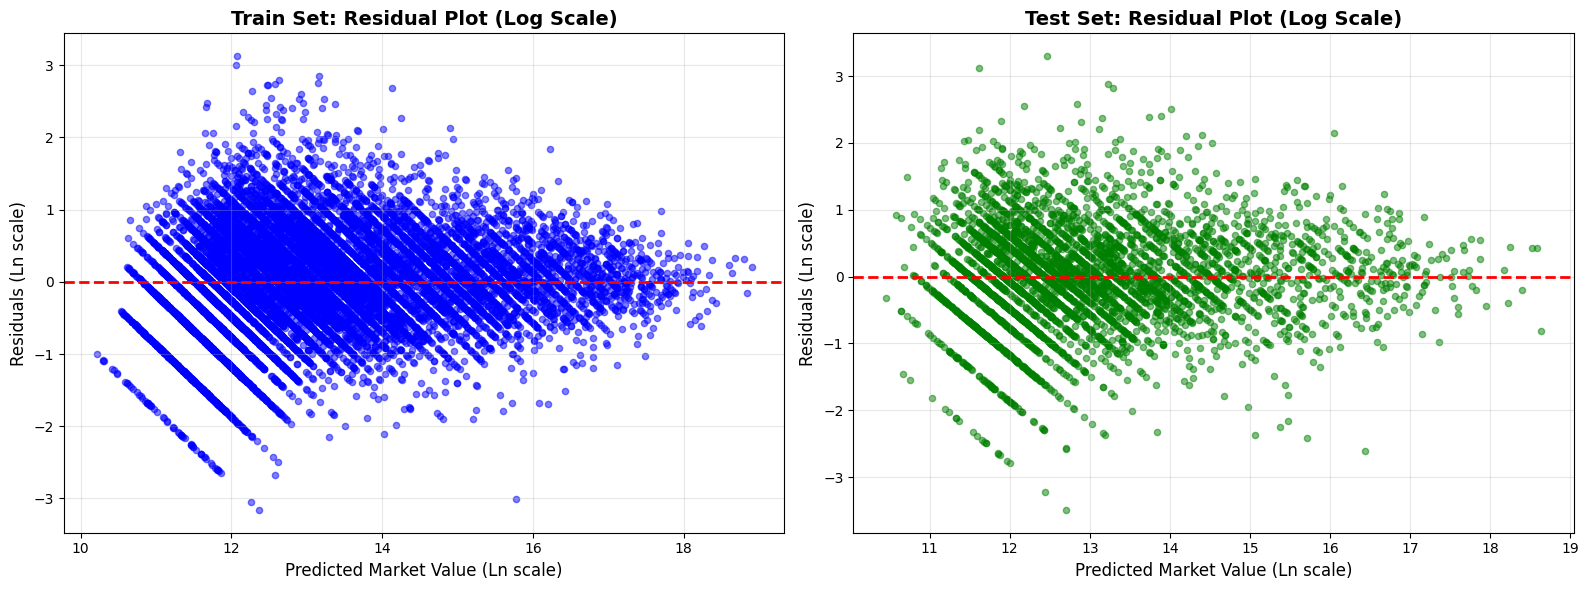

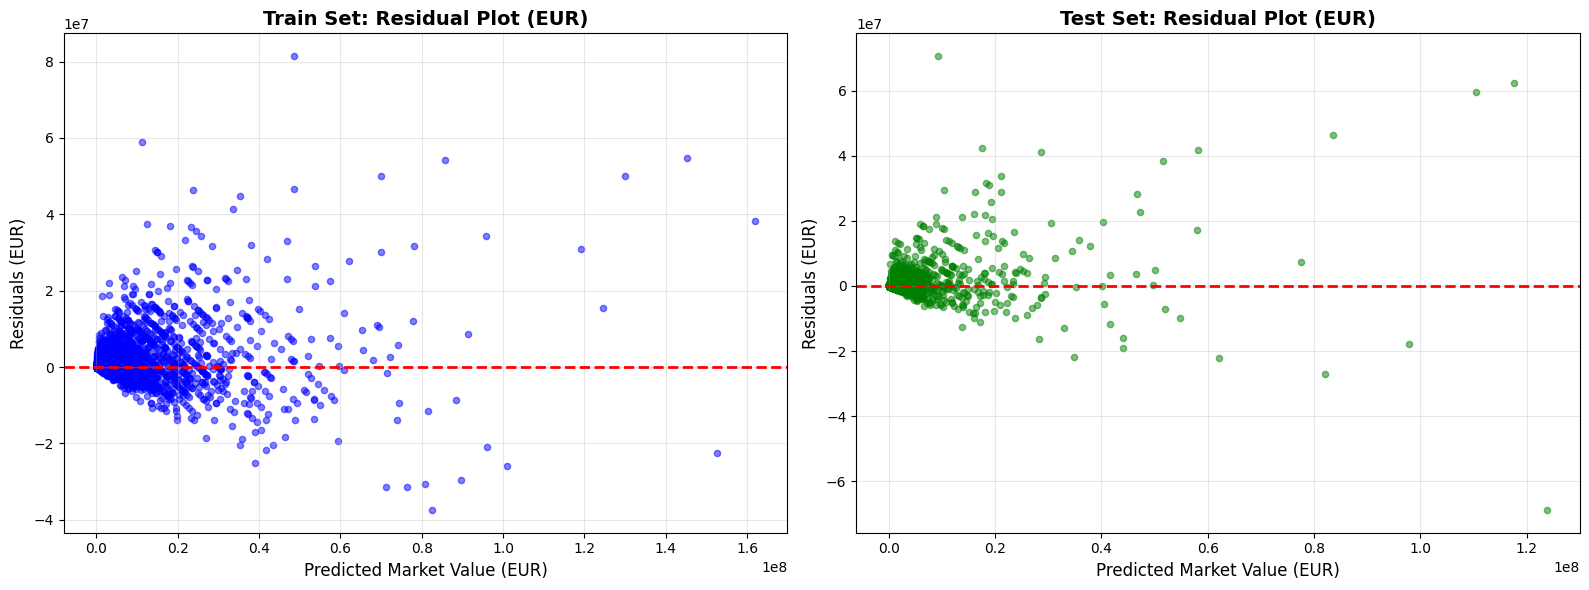

In [44]:
# Vẽ biểu đồ Residuals (Sai số) - LOG SCALE
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train residuals
train_residuals = y_train - y_train_pred
axes[0].scatter(y_train_pred, train_residuals, alpha=0.5, s=20, color='blue')
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[0].set_ylabel('Residuals (Ln scale)', fontsize=12)
axes[0].set_title('Train Set: Residual Plot (Log Scale)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Test residuals
test_residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, test_residuals, alpha=0.5, s=20, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[1].set_ylabel('Residuals (Ln scale)', fontsize=12)
axes[1].set_title('Test Set: Residual Plot (Log Scale)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Vẽ biểu đồ Residuals - EUR SCALE
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train residuals (EUR)
train_residuals_eur = y_train_eur - y_train_pred_eur
axes[0].scatter(y_train_pred_eur, train_residuals_eur, alpha=0.5, s=20, color='blue')
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Market Value (EUR)', fontsize=12)
axes[0].set_ylabel('Residuals (EUR)', fontsize=12)
axes[0].set_title('Train Set: Residual Plot (EUR)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Test residuals (EUR)
test_residuals_eur = y_test_eur - y_test_pred_eur
axes[1].scatter(y_test_pred_eur, test_residuals_eur, alpha=0.5, s=20, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Market Value (EUR)', fontsize=12)
axes[1].set_ylabel('Residuals (EUR)', fontsize=12)
axes[1].set_title('Test Set: Residual Plot (EUR)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### G. Feature Importance Analysis

Phân tích mức độ quan trọng của từng feature trong việc dự đoán giá trị cầu thủ.

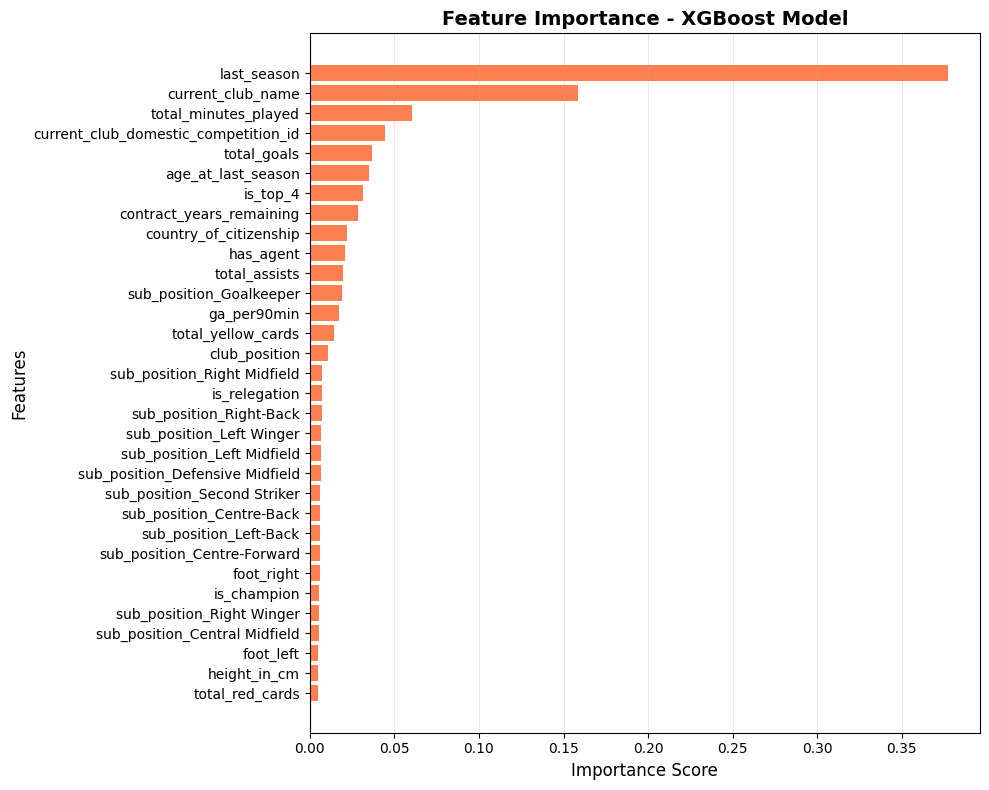


Top 10 Features quan trọng nhất:
                             feature  importance
                         last_season    0.377294
                   current_club_name    0.158406
                total_minutes_played    0.060506
current_club_domestic_competition_id    0.044368
                         total_goals    0.036765
                  age_at_last_season    0.035274
                            is_top_4    0.031214
            contract_years_remaining    0.028701
              country_of_citizenship    0.021892
                           has_agent    0.021022


In [45]:
# Lấy feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Vẽ biểu đồ Feature Importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='coral')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance - XGBoost Model', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 Features quan trọng nhất:")
print(feature_importance.head(10).to_string(index=False))

### H. Error Distribution Analysis

Phân tích phân phối của các sai số để hiểu rõ hơn về hiệu suất mô hình.

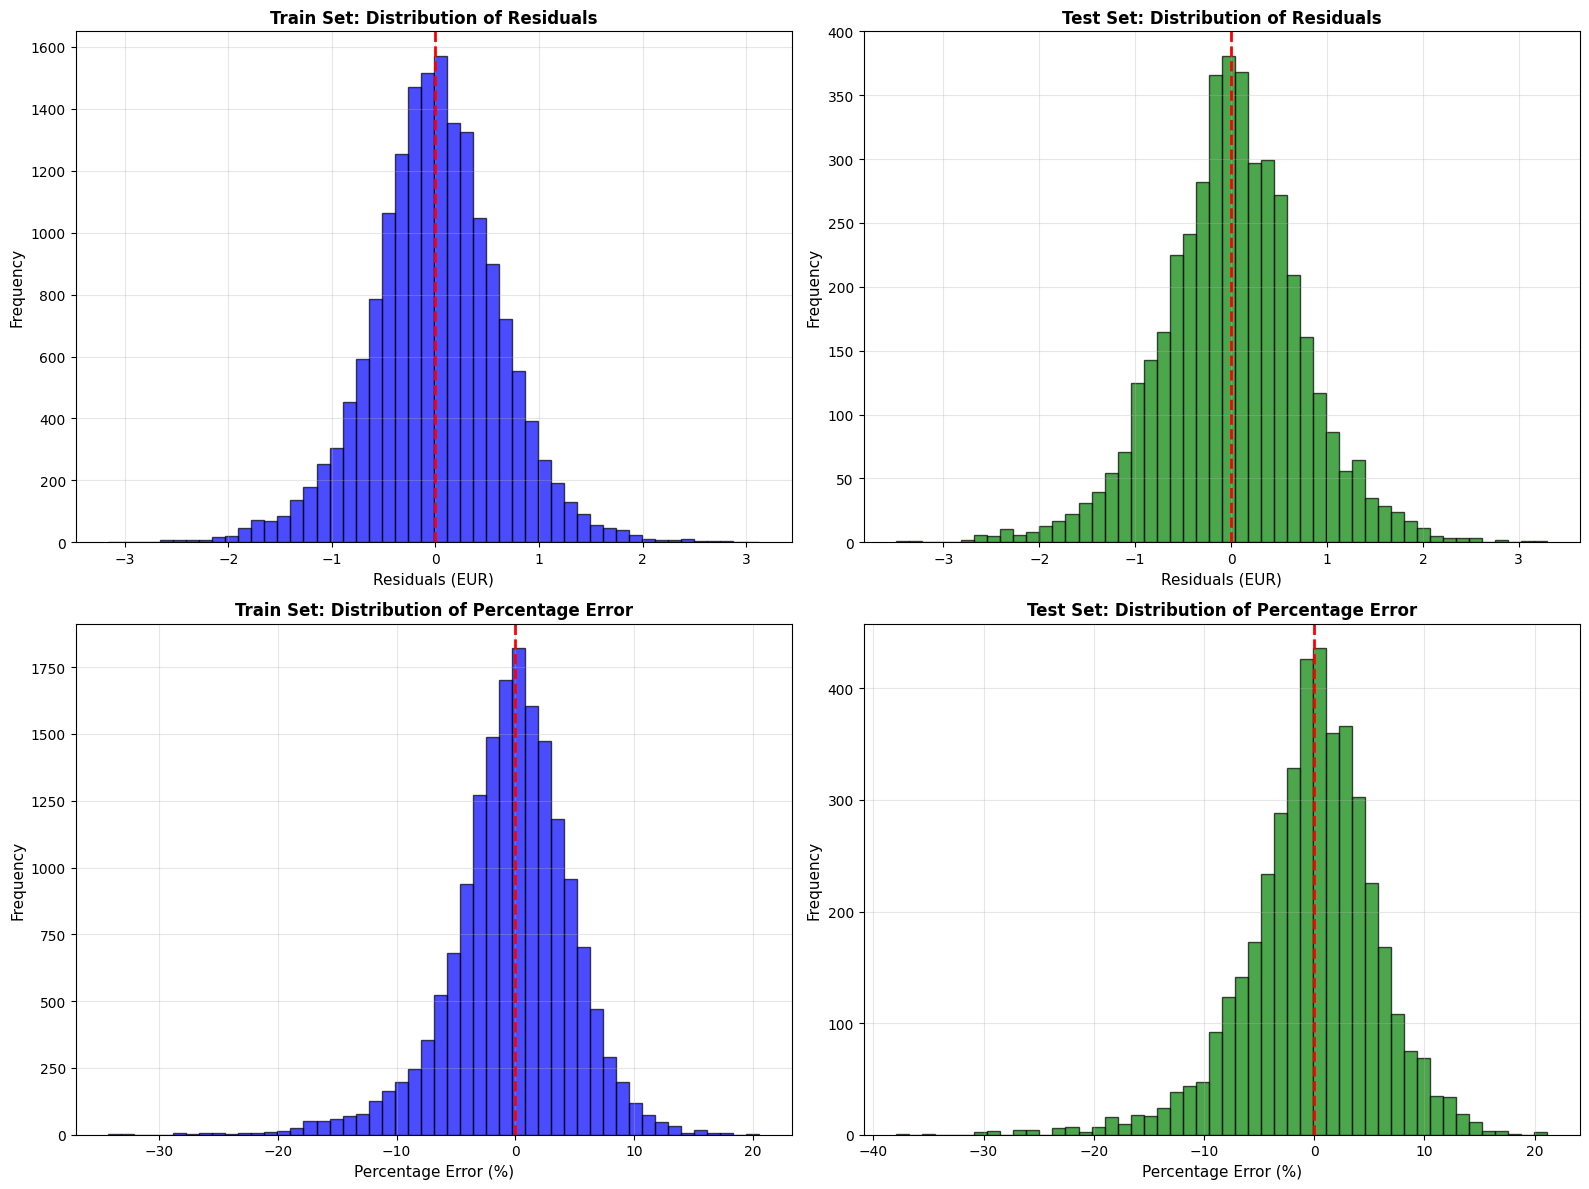

In [46]:
# Phân tích phân phối sai số
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Train set - Histogram of residuals
axes[0, 0].hist(train_residuals, bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0, 0].set_xlabel('Residuals (EUR)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Train Set: Distribution of Residuals', fontsize=12, fontweight='bold')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].grid(alpha=0.3)

# Test set - Histogram of residuals
axes[0, 1].hist(test_residuals, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Residuals (EUR)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Test Set: Distribution of Residuals', fontsize=12, fontweight='bold')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].grid(alpha=0.3)

# Train set - Percentage error distribution
train_pct_error = ((y_train - y_train_pred) / y_train * 100).values
axes[1, 0].hist(train_pct_error, bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[1, 0].set_xlabel('Percentage Error (%)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Train Set: Distribution of Percentage Error', fontsize=12, fontweight='bold')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].grid(alpha=0.3)

# Test set - Percentage error distribution
test_pct_error = ((y_test - y_test_pred) / y_test * 100).values
axes[1, 1].hist(test_pct_error, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].set_xlabel('Percentage Error (%)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Test Set: Distribution of Percentage Error', fontsize=12, fontweight='bold')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### I. Sample Predictions

Xem một số dự đoán cụ thể để hiểu rõ hơn về hiệu suất của mô hình.

In [47]:
# Tạo dataframe với predictions (sử dụng EUR scale cho dễ hiểu)
test_results = pd.DataFrame({
    'Actual_Value_EUR': y_test_eur.values,
    'Predicted_Value_EUR': y_test_pred_eur,
    'Absolute_Error_EUR': np.abs(y_test_eur.values - y_test_pred_eur),
    'Percentage_Error': np.abs((y_test_eur.values - y_test_pred_eur) / y_test_eur.values * 100)
})

# Top 10 dự đoán tốt nhất (sai số thấp nhất)
print("="*80)
print("TOP 10 DỰ ĐOÁN TỐT NHẤT (Sai số thấp nhất):")
print("="*80)
best_predictions = test_results.nsmallest(10, 'Absolute_Error_EUR')
for idx, row in best_predictions.iterrows():
    print(f"Actual: {row['Actual_Value_EUR']:>12,.0f} EUR | "
          f"Predicted: {row['Predicted_Value_EUR']:>12,.0f} EUR | "
          f"Error: {row['Absolute_Error_EUR']:>10,.0f} EUR ({row['Percentage_Error']:>5.2f}%)")

# Top 10 dự đoán tệ nhất (sai số cao nhất)
print("\n" + "="*80)
print("TOP 10 DỰ ĐOÁN TỆ NHẤT (Sai số cao nhất):")
print("="*80)
worst_predictions = test_results.nlargest(10, 'Absolute_Error_EUR')
for idx, row in worst_predictions.iterrows():
    print(f"Actual: {row['Actual_Value_EUR']:>12,.0f} EUR | "
          f"Predicted: {row['Predicted_Value_EUR']:>12,.0f} EUR | "
          f"Error: {row['Absolute_Error_EUR']:>10,.0f} EUR ({row['Percentage_Error']:>5.2f}%)")

TOP 10 DỰ ĐOÁN TỐT NHẤT (Sai số thấp nhất):
Actual:      450,000 EUR | Predicted:      450,005 EUR | Error:          5 EUR ( 0.00%)
Actual:      250,000 EUR | Predicted:      249,973 EUR | Error:         27 EUR ( 0.01%)
Actual:      150,000 EUR | Predicted:      149,957 EUR | Error:         43 EUR ( 0.03%)
Actual:       50,000 EUR | Predicted:       49,937 EUR | Error:         63 EUR ( 0.13%)
Actual:      325,000 EUR | Predicted:      325,094 EUR | Error:         94 EUR ( 0.03%)
Actual:      300,000 EUR | Predicted:      300,114 EUR | Error:        114 EUR ( 0.04%)
Actual:      100,000 EUR | Predicted:      100,115 EUR | Error:        115 EUR ( 0.11%)
Actual:      100,000 EUR | Predicted:      100,131 EUR | Error:        131 EUR ( 0.13%)
Actual:      100,000 EUR | Predicted:       99,787 EUR | Error:        213 EUR ( 0.21%)
Actual:      250,000 EUR | Predicted:      250,217 EUR | Error:        217 EUR ( 0.09%)

TOP 10 DỰ ĐOÁN TỆ NHẤT (Sai số cao nhất):
Actual:   80,000,000 EUR | Predic

### J. Results & Interpretation

#### Kết quả chính:

In [48]:
# Tổng hợp kết quả
print("\n" + "="*80)
print("TỔNG HỢP KẾT QUẢ MÔ HÌNH XGBOOST")
print("="*80)

print("\n📊 METRICS TRÊN Ln SCALE:")
comparison_df_log = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (Ln)', 'RMSE (Ln)'],
    'Train Set': [
        f"{train_metrics['R2_log']:.4f}",
        f"{train_metrics['MAE_log']:.4f}",
        f"{train_metrics['RMSE_log']:.4f}"
    ],
    'Test Set': [
        f"{test_metrics['R2_log']:.4f}",
        f"{test_metrics['MAE_log']:.4f}",
        f"{test_metrics['RMSE_log']:.4f}"
    ]
})
print(comparison_df_log.to_string(index=False))

print("\n" + "="*80)
print("💶 METRICS TRÊN EUR SCALE (INVERSE TRANSFORMED):")
comparison_df_eur = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (EUR)', 'RMSE (EUR)', 'MAPE (%)'],
    'Train Set': [
        f"{train_metrics['R2_eur']:.4f}",
        f"{train_metrics['MAE_eur']:,.0f}",
        f"{train_metrics['RMSE_eur']:,.0f}",
        f"{train_metrics['MAPE_eur']:.2f}"
    ],
    'Test Set': [
        f"{test_metrics['R2_eur']:.4f}",
        f"{test_metrics['MAE_eur']:,.0f}",
        f"{test_metrics['RMSE_eur']:,.0f}",
        f"{test_metrics['MAPE_eur']:.2f}"
    ]
})
print(comparison_df_eur.to_string(index=False))
print("="*80)

# Đánh giá overfitting
r2_diff = train_metrics['R2_eur'] - test_metrics['R2_eur']
print(f"\nChênh lệch R² giữa Train và Test: {r2_diff:.4f}")
if r2_diff < 0.05:
    print("→ Mô hình KHÔNG bị overfitting (chênh lệch nhỏ)")
elif r2_diff < 0.15:
    print("→ Mô hình có dấu hiệu overfitting NHẸ")
else:
    print("→ Mô hình bị overfitting NGHIÊM TRỌNG")


TỔNG HỢP KẾT QUẢ MÔ HÌNH XGBOOST

📊 METRICS TRÊN Ln SCALE:
   Metric Train Set Test Set
 R² Score    0.8425   0.7836
 MAE (Ln)    0.4818   0.5602
RMSE (Ln)    0.6311   0.7357

💶 METRICS TRÊN EUR SCALE (INVERSE TRANSFORMED):
    Metric Train Set  Test Set
  R² Score    0.8560    0.7845
 MAE (EUR)   805,672   957,858
RMSE (EUR) 2,868,630 3,648,204
  MAPE (%)     57.13     71.00

Chênh lệch R² giữa Train và Test: 0.0716
→ Mô hình có dấu hiệu overfitting NHẸ


### K. Interpretation & Insights

#### Trả lời câu hỏi: Có thể dự đoán Market Value hay không?

**1. Độ chính xác của mô hình:**
- **R² Score**: Cho biết mô hình giải thích được bao nhiêu % biến động của giá trị cầu thủ
  - Nếu R² > 0.7: Mô hình rất tốt, có thể dự đoán hiệu quả
  - Nếu 0.5 < R² < 0.7: Mô hình khá tốt, có thể sử dụng với một số cảnh báo
  - Nếu R² < 0.5: Mô hình chưa đủ tốt để áp dụng thực tế

- **MAPE (Mean Absolute Percentage Error)**: Sai số phần trăm trung bình
  - Nếu MAPE < 20%: Dự đoán khá chính xác
  - Nếu 20% < MAPE < 40%: Dự đoán ở mức chấp nhận được
  - Nếu MAPE > 40%: Dự đoán kém chính xác

**2. Các yếu tố ảnh hưởng đến độ chính xác:**
- **Features quan trọng nhất**: Dựa vào Feature Importance để xác định
- **Chất lượng dữ liệu**: Missing values, outliers có thể ảnh hưởng
- **Độ phức tạp của thị trường**: Yếu tố phi lý tính (hype, marketing) không có trong data

**3. Khả năng áp dụng thực tế:**
- Mô hình có thể làm công cụ **tham khảo** cho việc định giá
- **KHÔNG nên** dùng làm công cụ duy nhất để ra quyết định
- Cần kết hợp với đánh giá chuyên môn từ scouts và analysts

**4. Hạn chế của mô hình:**
- Không capture được các yếu tố phi định lượng (tiềm năng phát triển, leadership, mindset)
- Không tính đến yếu tố cung-cầu của thị trường chuyển nhượng
-


In [49]:
# Kết luận cuối cùng (dùng EUR metrics vì dễ hiểu hơn)
print("\n" + "="*80)
print("KẾT LUẬN")
print("="*80)

# Dùng R² và MAPE trên EUR scale để đánh giá
r2_test = test_metrics['R2_eur']
mape_test = test_metrics['MAPE_eur']

if r2_test > 0.7 and mape_test < 25:
    conclusion = "CÓ - Mô hình dự đoán hiệu quả"
    detail = f"""
    Mô hình XGBoost đạt R² = {r2_test:.4f} trên tập test (EUR scale), cho thấy 
    có thể dự đoán giá trị cầu thủ với độ chính xác cao. Mô hình giải thích được 
    {r2_test*100:.1f}% biến động của market value.
    
    MAPE = {mape_test:.2f}% cho thấy sai số trung bình ở mức chấp nhận được.
    MAE = {test_metrics['MAE_eur']:,.0f} EUR - sai số tuyệt đối trung bình.
    
    ✓ Mô hình CÓ THỂ được sử dụng làm công cụ hỗ trợ định giá cầu thủ
    ✓ Kết hợp với đánh giá chuyên môn sẽ cho kết quả tốt nhất
    ✓ Log transformation giúp mô hình xử lý tốt dải giá trị rộng
    """
elif r2_test > 0.5:
    conclusion = "CÓ - Nhưng với một số hạn chế"
    detail = f"""
    Mô hình XGBoost đạt R² = {r2_test:.4f} trên tập test (EUR scale), cho thấy 
    có thể dự đoán giá trị cầu thủ ở mức TRUNG BÌNH. Mô hình giải thích được 
    {r2_test*100:.1f}% biến động của market value.
    
    MAPE = {mape_test:.2f}% cho thấy sai số khá lớn trong một số trường hợp.
    MAE = {test_metrics['MAE_eur']:,.0f} EUR - sai số tuyệt đối trung bình.
    
    ⚠ Mô hình CÓ THỂ sử dụng nhưng cần thận trọng
    ⚠ Nên kết hợp chặt chẽ với đánh giá từ chuyên gia
    ⚠ Không nên dùng cho các quyết định quan trọng
    """
else:
    conclusion = "KHÔNG - Mô hình chưa đủ hiệu quả"
    detail = f"""
    Mô hình XGBoost chỉ đạt R² = {r2_test:.4f} trên tập test (EUR scale), cho thấy
    KHÔNG THỂ dự đoán giá trị cầu thủ một cách hiệu quả. Mô hình chỉ giải thích được 
    {r2_test*100:.1f}% biến động của market value.
    
    MAPE = {mape_test:.2f}% cho thấy sai số quá lớn.
    MAE = {test_metrics['MAE_eur']:,.0f} EUR - sai số tuyệt đối trung bình quá cao.
    
    ✗ Mô hình KHÔNG NÊN được sử dụng cho mục đích định giá thực tế
    ✗ Cần thu thập thêm dữ liệu hoặc features khác
    ✗ Có thể do thị trường chuyển nhượng phụ thuộc nhiều vào yếu tố phi lý tính
    """

print(f"\nCâu trả lời: {conclusion}")
print(detail)
print("\n💡 LƯU Ý: Mô hình sử dụng Ln transformation để xử lý tốt hơn")
print("   dải giá trị rộng của market value (từ vài nghìn đến hàng trăm triệu EUR)")
print("="*80)


KẾT LUẬN

Câu trả lời: CÓ - Nhưng với một số hạn chế

    Mô hình XGBoost đạt R² = 0.7845 trên tập test (EUR scale), cho thấy 
    có thể dự đoán giá trị cầu thủ ở mức TRUNG BÌNH. Mô hình giải thích được 
    78.4% biến động của market value.

    MAPE = 71.00% cho thấy sai số khá lớn trong một số trường hợp.
    MAE = 957,858 EUR - sai số tuyệt đối trung bình.

    ⚠ Mô hình CÓ THỂ sử dụng nhưng cần thận trọng
    ⚠ Nên kết hợp chặt chẽ với đánh giá từ chuyên gia
    ⚠ Không nên dùng cho các quyết định quan trọng
    

💡 LƯU Ý: Mô hình sử dụng Ln transformation để xử lý tốt hơn
   dải giá trị rộng của market value (từ vài nghìn đến hàng trăm triệu EUR)


In [50]:
# 1. Load dữ liệu gốc để lấy thông tin thống kê cho việc mã hóa (Target Encoding)
# Giả sử bạn đã có df_raw từ file 'processed_players_data.csv'
if 'df_raw' not in locals():
    df_raw = pd.read_csv('../data/processed_players_data.csv')

# Tạo lại cột logarit của giá trị chuyển nhượng để làm cơ sở tính toán
# (Dùng Ln giống như cách bạn đã làm trong training)
df_raw['market_value_log'] = np.log1p(df_raw['market_value_in_eur'])

# 2. Tạo các bộ từ điển (Mapping dictionaries)
# Nguyên lý: Tính giá trị trung bình log(market_value) cho từng Club, Country, Competition
# Nếu gặp giá trị mới chưa từng thấy, ta sẽ dùng giá trị trung bình toàn cầu (global mean)

global_mean_mv = df_raw['market_value_log'].mean()

# Mapping cho CLB
club_map = df_raw.groupby('current_club_name')['market_value_log'].mean().to_dict()

# Mapping cho Quốc tịch
country_map = df_raw.groupby('country_of_citizenship')['market_value_log'].mean().to_dict()

# Mapping cho Giải đấu
comp_map = df_raw.groupby('current_club_domestic_competition_id')['market_value_log'].mean().to_dict()

print("Đã tạo xong bộ từ điển Mapping thành công!")
print(f"- Số lượng CLB đã học: {len(club_map)}")
print(f"- Số lượng Quốc tịch đã học: {len(country_map)}")
print(f"- Giá trị trung bình toàn cầu (Global Mean): {global_mean_mv:.4f}")

Đã tạo xong bộ từ điển Mapping thành công!
- Số lượng CLB đã học: 437
- Số lượng Quốc tịch đã học: 170
- Giá trị trung bình toàn cầu (Global Mean): 13.0248


In [51]:
def predict_player_value(player_data, model, feature_columns):
    """
    Hàm dự đoán giá trị cầu thủ từ dữ liệu thô.
    
    Args:
        player_data (dict): Dictionary chứa thông tin cầu thủ nhập tay.
        model: Mô hình XGBoost đã train.
        feature_columns (list): Danh sách các cột features được dùng lúc train (X_train.columns).
        
    Returns:
        DataFrame kết quả dự đoán (Log và EUR).
    """
    
    # 1. Khởi tạo DataFrame với tất cả các cột bằng 0, đúng theo cấu trúc lúc train
    input_df = pd.DataFrame(0, index=[0], columns=feature_columns)
    
    # 2. Điền các dữ liệu số cơ bản (Numerical Features)
    input_df['age_at_last_season'] = player_data.get('age', 25)
    input_df['height_in_cm'] = player_data.get('height', 180)
    input_df['total_goals'] = player_data.get('goals', 0)
    input_df['total_assists'] = player_data.get('assists', 0)
    input_df['total_minutes_played'] = player_data.get('minutes', 0)
    input_df['total_yellow_cards'] = player_data.get('yellow_cards', 0)
    input_df['total_red_cards'] = player_data.get('red_cards', 0)
    input_df['has_agent'] = 1 if player_data.get('has_agent', False) else 0
    input_df['ga_per90min'] = player_data.get('ga_per90min', 0.0)
    input_df['contract_years_remaining'] = player_data.get('contract_years', 1)
    input_df['club_position'] = player_data.get('club_rank', 10)
    
    # 3. [MỚI] Điền các thông tin bổ sung (Kiểm tra xem model có dùng cột này không trước khi điền)
    extra_fields = {
        'last_season': 'last_season', 
        'is_champion': 'is_champion', 
        'is_top_4': 'is_top_4', 
        'is_relegation': 'is_relegation'
    }
    
    for key, col_name in extra_fields.items():
        if col_name in input_df.columns:
            input_df[col_name] = player_data.get(key, 0)

    # 4. Xử lý Target Encoding (Sử dụng map đã tạo)
    # Club Name
    club_name = player_data.get('club_name', '')
    if 'current_club_name' in input_df.columns:
        input_df['current_club_name'] = club_map.get(club_name, global_mean_mv)
    
    # Country
    country = player_data.get('country', '')
    if 'country_of_citizenship' in input_df.columns:
        input_df['country_of_citizenship'] = country_map.get(country, global_mean_mv)
    
    # Competition
    comp = player_data.get('competition_id', '')
    if 'current_club_domestic_competition_id' in input_df.columns:
        input_df['current_club_domestic_competition_id'] = comp_map.get(comp, global_mean_mv)

    # 5. Xử lý One-Hot Encoding (Sub Position & Foot)
    # Sub Position
    sub_pos = player_data.get('sub_position', '') 
    sub_pos_col = f"sub_position_{sub_pos}"
    if sub_pos_col in input_df.columns:
        input_df[sub_pos_col] = 1
        
    # Foot
    foot = player_data.get('foot', '')
    foot_col = f"foot_{foot}"
    if foot_col in input_df.columns:
        input_df[foot_col] = 1

    # 6. Thực hiện dự đoán
    try:
        pred_log = model.predict(input_df)[0]
        pred_eur = np.expm1(pred_log)  # Dùng expm1 vì train bằng log1p
        return input_df, pred_log, pred_eur
    except Exception as e:
        print(f"Lỗi khi dự đoán: {e}")
        return input_df, 0, 0

In [60]:
# --- NHẬP LIỆU CẦU THỦ MỚI TẠI ĐÂY ---
new_player = {
    # Thông tin cơ bản
    'age': 36,
    'height': 184,                 # cm
    'country': 'England',            # Phải gõ đúng tên tiếng Anh như trong dữ liệu gốc
    
    # Vị trí và Chân thuận
    'sub_position': 'Central Midfield',  # Ví dụ: Centre-Forward, Centre-Back, Left Winger...
    'foot': 'right',                     # 'left' hoặc 'right'
    
    # CLB và Giải đấu
    'club_name': 'Manchester City Football Club',         # Tên CLB hiện tại
    'competition_id': 'premier-league',          # bundesliga, premier-league, laliga, serie-a...
    'club_rank': 2.0,                    # Thứ hạng của CLB mùa trước
    
    # Thống kê mùa giải
    'goals': 6,
    'assists': 2,
    'minutes': 1421,
    'yellow_cards': 5,
    'red_cards': 0,
    'ga_per90min': 0.51,                  # (Goals + Assists) / 90 mins
    
    # Hợp đồng
    'has_agent': False,                   # Có người đại diện hay không
    'contract_years': 3,                  # Số năm hợp đồng còn lại
    
    # Thông tin bổ sung
    'last_season': 2014,                  # Mùa giải gần nhất
    'is_champion': 0,                     # CLB có vô địch không (0 hoặc 1)
    'is_top_4': 1,                        # CLB có vào top 4 không (0 hoặc 1)
    'is_relegation': 0                    # CLB có xuống hạng không (0 hoặc 1)
}

# --- GỌI HÀM DỰ ĐOÁN ---
# Lưu ý: 'xgb_model' và 'features' (list cột của X_train) phải được định nghĩa từ các bước train trước đó
try:
    # Lấy danh sách features từ X_train (đã chạy ở cell train trước đó)
    feature_cols = X_train.columns.tolist()
    
    # Thực hiện dự đoán
    input_df_processed, pred_log, pred_eur = predict_player_value(new_player, xgb_model, feature_cols)

    print("-" * 50)
    print(f"DỰ ĐOÁN GIÁ TRỊ CHUYỂN NHƯỢNG (MARKET VALUE)")
    print("-" * 50)
    print(f"Thông tin cầu thủ đã nhập:")
    print(f"  - Tuổi: {new_player['age']}")
    print(f"  - Chiều cao: {new_player['height']} cm")
    print(f"  - Quốc tịch: {new_player['country']}")
    print(f"  - Vị trí: {new_player['sub_position']}")
    print(f"  - Chân thuận: {'Trái' if new_player['foot'] == 'left' else 'Phải'}")
    print(f"  - Câu lạc bộ: {new_player['club_name']}")
    print(f"  - Giải đấu: {new_player['competition_id']}")
    print(f"  - Thứ hạng CLB: {new_player['club_rank']}")
    print(f"  - Bàn thắng: {new_player['goals']}")
    print(f"  - Kiến tạo: {new_player['assists']}")
    print(f"  - Phút thi đấu: {new_player['minutes']}")
    print(f"  - Thẻ vàng: {new_player['yellow_cards']}")
    print(f"  - Thẻ đỏ: {new_player['red_cards']}")
    print(f"  - G+A/90 phút: {new_player['ga_per90min']}")
    print(f"  - Có người đại diện: {'Có' if new_player['has_agent'] else 'Không'}")
    print(f"  - Số năm hợp đồng còn lại: {new_player['contract_years']}")
    print("-" * 50)
    print(f"Kết quả dự đoán (Ln scale):  {pred_log:.4f}")
    print(f"Kết quả dự đoán (EUR):          € {pred_eur:,.0f}")
    print("-" * 50)
    
except NameError:
    print("Lỗi: Bạn cần chạy các cell huấn luyện mô hình (fit model) để có biến 'xgb_model' và 'X_train' trước khi chạy cell này.")
except Exception as e:
    print(f"Đã xảy ra lỗi: {e}")

--------------------------------------------------
DỰ ĐOÁN GIÁ TRỊ CHUYỂN NHƯỢNG (MARKET VALUE)
--------------------------------------------------
Thông tin cầu thủ đã nhập:
  - Tuổi: 36
  - Chiều cao: 184 cm
  - Quốc tịch: England
  - Vị trí: Central Midfield
  - Chân thuận: Phải
  - Câu lạc bộ: Manchester City Football Club
  - Giải đấu: premier-league
  - Thứ hạng CLB: 2.0
  - Bàn thắng: 6
  - Kiến tạo: 2
  - Phút thi đấu: 1421
  - Thẻ vàng: 5
  - Thẻ đỏ: 0
  - G+A/90 phút: 0.51
  - Có người đại diện: Không
  - Số năm hợp đồng còn lại: 3
--------------------------------------------------
Kết quả dự đoán (Ln scale):  13.6157
Kết quả dự đoán (EUR):          € 818,873
--------------------------------------------------


In [86]:
# --- 1. LẤY MẪU NGẪU NHIÊN 10 CẦU THỦ TỪ DỮ LIỆU GỐC ---
# Chúng ta dùng file gốc vì file encoded (test_data_encoded) đã bị mất cột Tên cầu thủ

# Lấy ngẫu nhiên 10 cầu thủ
# (Để đảm bảo tính khách quan, lý tưởng nhất là lọc những index thuộc tập Test, 
# nhưng ở đây ta lấy ngẫu nhiên để demo nhanh khả năng dự đoán)
# random_samples = df_raw.sample(n=10, random_state=42) # random_state để kết quả cố định mỗi lần chạy
random_samples = df_raw.sample(n=10) # Lấy ngẫu nhiên mỗi lần chạy

print(f"{'TÊN CẦU THỦ':<25} | {'THỰC TẾ (€)':<13} | {'DỰ ĐOÁN (€)':<13} | {'CHÊNH LỆCH (€)':<13} | {'SAI SỐ (%)':<10}")
print("-" * 85)

results = []
feature_cols = X_train.columns.tolist() # Danh sách cột features từ model đã train

# --- 2. DỰ ĐOÁN VÀ SO SÁNH ---
for index, row in random_samples.iterrows():
    # A. Chuẩn bị dữ liệu input từ dòng hiện tại (Mapping từ cột CSV sang key của hàm predict)
    player_input = {
        'age': row['age_at_last_season'],
        'height': row['height_in_cm'],
        'country': row['country_of_citizenship'],
        'sub_position': row['sub_position'],
        'foot': row['foot'],
        'club_name': row['current_club_name'],
        'competition_id': row['current_club_domestic_competition_id'],
        'club_rank': row['club_position'],
        'goals': row['total_goals'],
        'assists': row['total_assists'],
        'minutes': row['total_minutes_played'],
        'yellow_cards': row['total_yellow_cards'],
        'red_cards': row['total_red_cards'],
        'ga_per90min': row['ga_per90min'],
        'has_agent': row['has_agent'],
        'contract_years': row['contract_years_remaining'],
        'last_season': row['last_season'],
        'is_champion': row['is_champion'],
        'is_top_4': row['is_top_4'],
        'is_relegation': row['is_relegation']
    }

    # Xử lý dữ liệu thiếu (nếu có)
    if pd.isna(player_input['sub_position']): player_input['sub_position'] = 'Unknown'
    if pd.isna(player_input['foot']): player_input['foot'] = 'right'

    # B. Gọi hàm dự đoán
    try:
        _, pred_log, pred_eur = predict_player_value(player_input, xgb_model, feature_cols)
        
        # C. Lấy giá trị thực tế
        actual_eur = row['market_value_in_eur']
        
        # D. Tính toán sai số
        diff = pred_eur - actual_eur
        error_percent = (abs(diff) / actual_eur) * 100
        
        results.append(error_percent)
        
        # E. In kết quả từng dòng
        name_display = (row['name'][:30] + '..') if len(row['name']) > 30 else row['name']
        
        print(f"{name_display:<25} | {actual_eur:>13,.0f} | {pred_eur:>13,.0f} | {diff:>+13,.0f} | {error_percent:>9.2f}%")
        
    except Exception as e:
        print(f"Lỗi khi dự đoán cầu thủ {row['name']}: {e}")

print("-" * 85)

# --- 3. TỔNG KẾT ĐỘ CHÍNH XÁC ---
if results:
    mape = np.mean(results) # Mean Absolute Percentage Error
    accuracy_proxy = 100 - mape
    
    print(f"\n>> TỔNG KẾT TRÊN 10 CẦU THỦ NGẪU NHIÊN:")
    print(f"   - Trung bình sai số (MAPE): {mape:.2f}%")
    print(f"   - Độ chính xác ước tính (100% - MAPE): {accuracy_proxy:.2f}%")
    
    if accuracy_proxy < 0:
        print("   (Lưu ý: Độ chính xác âm cho thấy sai số trung bình lớn hơn 100%, mô hình cần cải thiện thêm)")

TÊN CẦU THỦ               | THỰC TẾ (€)   | DỰ ĐOÁN (€)   | CHÊNH LỆCH (€) | SAI SỐ (%)
-------------------------------------------------------------------------------------
Xavi Quintillà            |       600,000 |       549,762 |       -50,238 |      8.37%
Christian Kum             |       200,000 |       116,989 |       -83,011 |     41.51%
Perry Kitchen             |       300,000 |       381,349 |       +81,349 |     27.12%
Martí Riverola            |       250,000 |       212,952 |       -37,048 |     14.82%
Tom Taiwo                 |       225,000 |       167,098 |       -57,902 |     25.73%
Ermedin Demirovic         |    22,000,000 |    23,771,576 |    +1,771,576 |      8.05%
Alejandro Cantero         |     1,400,000 |     1,094,996 |      -305,004 |     21.79%
Marvin Obuz               |       300,000 |       241,225 |       -58,775 |     19.59%
Raúl Guti                 |     2,000,000 |     1,500,202 |      -499,798 |     24.99%
Mohamadou Sissoko         |       100,000 |